# Intermittent or Sparse Data 
> In this notebook, we'll implement models for intermittent or sparse data

Intermittent or sparse data has very few non-zero observations. This type of data is hard to forecast because the zero values increase the uncertainty about the underlying patterns in the data. Furthermore, once a non-zero observation occurs, there can be considerable variation in its size. Intermittent time series are common in many industries, including finance, retail, transportation, and energy. Given the ubiquity of this type of series, special methods have been developed to forecast them. The first was from [Croston (1972)](#ref), followed by several variants and by different aggregation frameworks. 

[StatsForecast](../../index) has implemented several models to forecast intermittent time series. By the end of this tutorial, you'll have a good understanding of these models and how to use them. 

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Train models for intermittent data
4. Plot forecasts and compute accuracy

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/IntermittentData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

::: {.callout-tip}
For forecasting at scale, we recommend you check [this notebook](https://www.databricks.com/blog/2022/12/06/intermittent-demand-forecasting-nixtla-databricks.html) done on Databricks.

::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation)

Install the necessary packages using `pip install statsforecast`

In [ ]:
pip install statsforecast -U

## Load and explore the data

For this example, we'll use a subset of the [M5 Competition](https://www.sciencedirect.com/science/article/pii/S0169207021001187#:~:text=The%20objective%20of%20the%20M5,the%20uncertainty%20around%20these%20forecasts) dataset. Each time series represents the unit sales of a particular product in a given Walmart store. At this level (product-store), most of the data is intermittent. 
We first need to import the data.

In [ ]:
#| echo: false
import multiprocessing as mp

In [ ]:
#| echo: false
mp.set_start_method('spawn')

In [ ]:
import pandas as pd

In [ ]:
uids = [
    'FOODS_1_001_CA_1',
    'FOODS_1_001_CA_2',
    'FOODS_1_001_CA_3',
    'FOODS_1_001_CA_4',
    'FOODS_1_001_TX_1',
    'FOODS_1_001_TX_2',
    'FOODS_1_001_TX_3',
    'FOODS_1_001_WI_1',
]
df = pd.read_parquet(
    'https://datasets-nixtla.s3.amazonaws.com/m5_y.parquet',
    filters=[('unique_id', 'in', uids)],
)

We can plot these series using the `plot_series` function from `utilsforecast.plotting`. This function has multiple parameters, and the required ones to generate the plots in this notebook are explained below. 

- `df`: A `pandas` dataframe with columns [`unique_id`, `ds`, `y`]. 
- `forecasts_df`: A `pandas` dataframe with columns [`unique_id`, `ds`] and models. 
- `plot_random`: Plots the time series randomly.
- `max_insample_length`: The maximum number of train/insample observations to be plotted. 
- `engine`: The library used to generate the plots. It can also be `matplotlib` for static plots. 

In [ ]:
from utilsforecast.plotting import plot_series

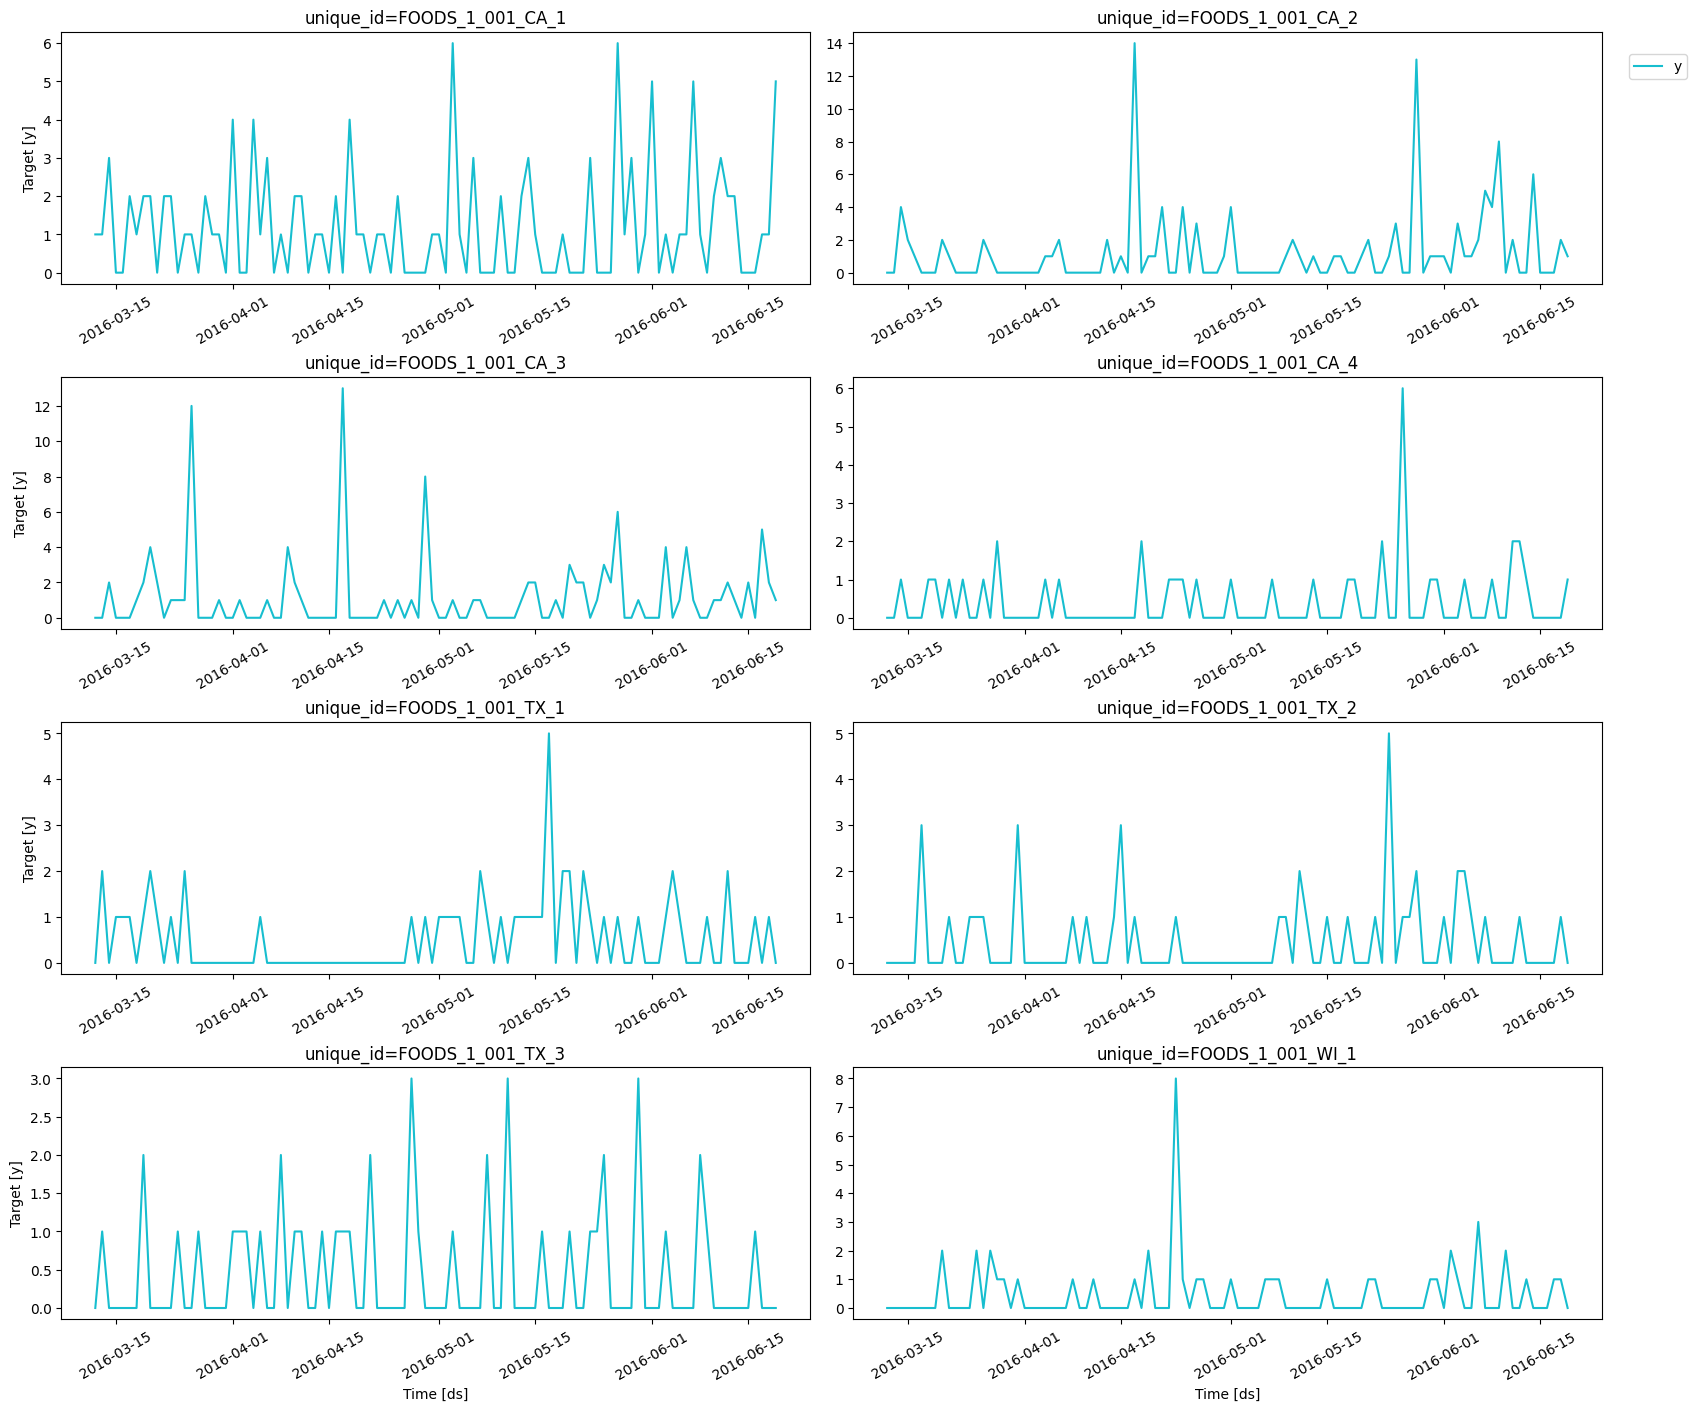

In [ ]:
plot_series(df, plot_random=False, max_insample_length=100)

Here we only plotted the last 100 observations, but we can visualize the complete history by removing `max_insample_length`. 
From these plots, we can confirm that the data is indeed intermittent since it has multiple periods with zero sales. In fact, in all cases but one, the median value is zero. 

In [ ]:
df.groupby('unique_id', observed=True)['y'].median()

unique_id
FOODS_1_001_CA_1    0.0
FOODS_1_001_CA_2    1.0
FOODS_1_001_CA_3    0.0
FOODS_1_001_CA_4    0.0
FOODS_1_001_TX_1    0.0
FOODS_1_001_TX_2    0.0
FOODS_1_001_TX_3    0.0
FOODS_1_001_WI_1    0.0
Name: y, dtype: float32

## Train models for intermittent data 

Before training any model, we need to separate the data in a train and a test set. The M5 Competition used the last 28 days as test set, so we'll do the same. 

In [ ]:
valid_start = df['ds'].unique()[-28]

train = df[df['ds'] < valid_start]
test = df[df['ds'] >= valid_start]

StatsForecast has efficient implementations of multiple models for intermittent data. The complete list of models available is [here](../../models). In this notebook, we'll use:

- [Agregate-Dissagregate Intermittent Demand Approach (ADIDA)](../models/ADIDA)
- [Croston Classic](../models/CrostonClassic)
- [Intermittent Multiple Aggregation Prediction Algorithm (IMAPA)](../models/IMAPA)
- [Teunter-Syntetos-Babai (TSB)](../models/TSB)

To use these models, we first need to import them from `statsforecast.models` and then we need to instantiate them. 

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import (
    ADIDA,
    CrostonClassic,
    IMAPA,
    TSB
)

# Create a list of models and instantiation parameters
models = [
    ADIDA(),
    CrostonClassic(),
    IMAPA(),
    TSB(alpha_d = 0.2, alpha_p = 0.2)
]

To instantiate a new StatsForecast object, we need the following parameters: 

- `models`: The list of models defined in the previous step.  
- `freq`: A string indicating the frequency of the data. See [pandas' available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). 
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores. 

In [ ]:
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
)

Now we're ready to generate the forecast. To do this, we'll use the `forecast` method, which requires the forecasting horizon (in this case, 28 days) as argument. 

The models for intermittent series that are currently available in StatsForecast can only generate point-forecasts. If prediction intervals are needed, then a [probabilisitic model](../../models) should be used. 

In [ ]:
horizon = 28
forecasts = sf.forecast(df=train, h=horizon)
forecasts.head()

,unique_id,ds,ADIDA,CrostonClassic,IMAPA,TSB
0,FOODS_1_001_CA_1,2016-05-23,0.791852,0.898247,0.705835,0.434313
1,FOODS_1_001_CA_1,2016-05-24,0.791852,0.898247,0.705835,0.434313
2,FOODS_1_001_CA_1,2016-05-25,0.791852,0.898247,0.705835,0.434313
3,FOODS_1_001_CA_1,2016-05-26,0.791852,0.898247,0.705835,0.434313
4,FOODS_1_001_CA_1,2016-05-27,0.791852,0.898247,0.705835,0.434313


Finally, we'll merge the forecast with the actual values. 

In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plot forecasts and compute accuracy

We can generate plots using the `plot_series` function described above. 

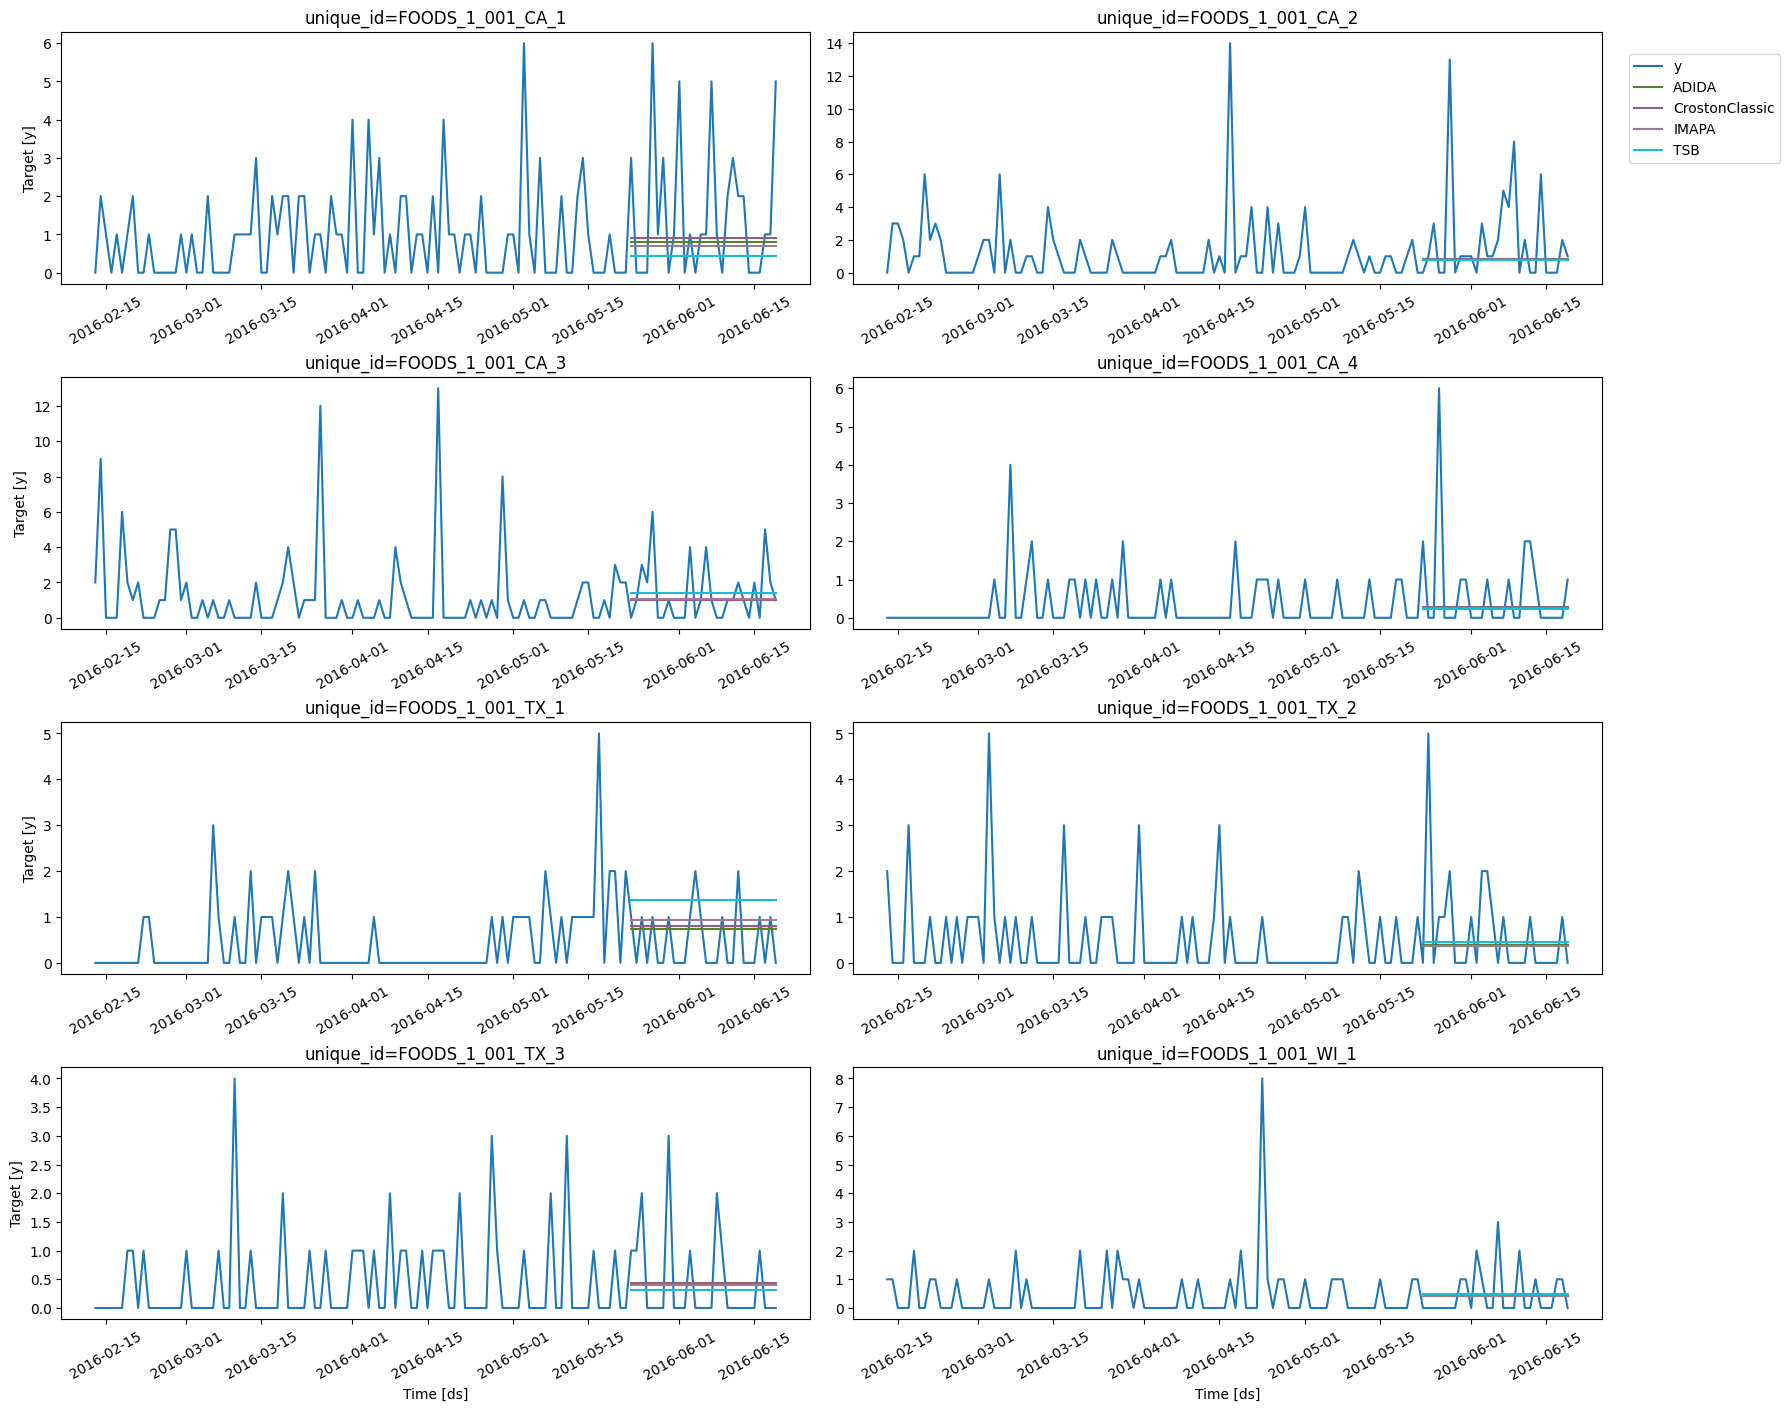

In [ ]:
plot_series(train, test, plot_random=False, max_insample_length=100)

To compute the accuracy of the forecasts, we'll use the Mean Average Error (MAE), which is the sum of the absolute errors divided by the number of forecasts.

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae

In [ ]:
evaluate(test, metrics=[mae], agg_fn='mean')

,metric,ADIDA,CrostonClassic,IMAPA,TSB
0,mae,0.948729,0.944071,0.957256,1.023126


Hence, on average, the forecasts are one unit off. 


## References 


[Croston, J. D. (1972). Forecasting and stock control for intermittent
  demands. Journal of the Operational Research Society, 23(3),
  289-303.](https://link.springer.com/article/10.1057/jors.1972.50)